In [18]:
import urbs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_style(style="whitegrid")

color_dict = {
    #Generation
    'Biomass power plants': '#00B050',
    'Coal power plants': '#7F7F7F',
    'Gas power plants': '#ED7D31',
    'Geothermal power plants': '#385723',
    'Hydro power plants': '#1F4E79',
    'Nuclear power plants': '#BF9000',
    'Oil power plants': '#843C0C',
    'Onshore wind parks': '#9DC3E6',
    'Photovoltaics': '#F4EF11',
    'Others': '#3B3838',
    'H2 power plants': '#3B3838',
    
    # Consumption
    'Electric chargers': '#0070C0',
    'Electricity (end-use)': '#00B0F0',
    'Process heating 100+ (electric heaters)': '#C55A11',
    'Process heating 100- (heat pumps)': '#BF9000',
    'Process heating 200+ (electric heaters)': '#843C0C',
    'Space heating (heat pumps)': '#548235',
    'Curtailment': '#767171'
}

In [35]:
# Load data for all years

years = [2020,
         2025, 
         2030, 
         2035, 
         2040, 
         2045, 
         2050]

df = {}
for year in years:
    df[year] = urbs.load(f"myopic/scenarios/noh2_limit/output_bayern_{year}.h5")._result

In [36]:
year = 2050

Text(0.5, 0.98, 'Monthly electricity generation and consumption in TWh (2050)')

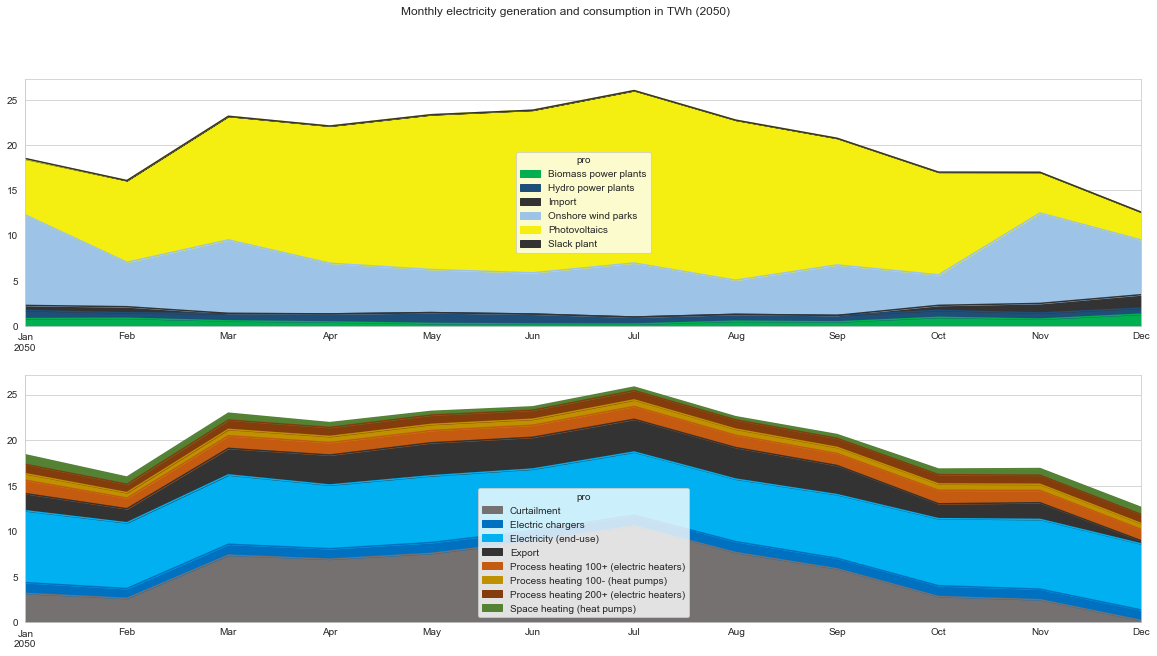

In [37]:
# Electricity generation

gen = (df[year]['e_pro_out']
 .unstack()['Elec']
 .dropna()
 .unstack()
 .replace(0, np.nan).dropna(axis = 1, how = "all")
 .replace(np.nan, 0)
 .reset_index()
 .drop(['t', 'stf', 'sit'], axis = 1)
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )

# Electricity consumption

con = (df[year]['e_pro_in']
 .unstack()['Elec']
 .dropna()
 .unstack()
 .replace(0, np.nan).dropna(axis = 1, how = "all")
 .replace(np.nan, 0)
 .reset_index()
 .drop(['t', 'stf', 'sit'], axis = 1)
 .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
 )


# Creating resampled plots
fig, axs = plt.subplots(2, 1, figsize = (20, 10))
(gen / 1e6).resample("M").sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in gen.columns], ax = axs[0])
(con / 1e6).resample('M').sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in con.columns], ax = axs[1])
fig.suptitle(f"Monthly electricity generation and consumption in TWh ({year})")

Text(0.5, 0.98, 'Weekly electricity generation and consumption in TWh (2050)')

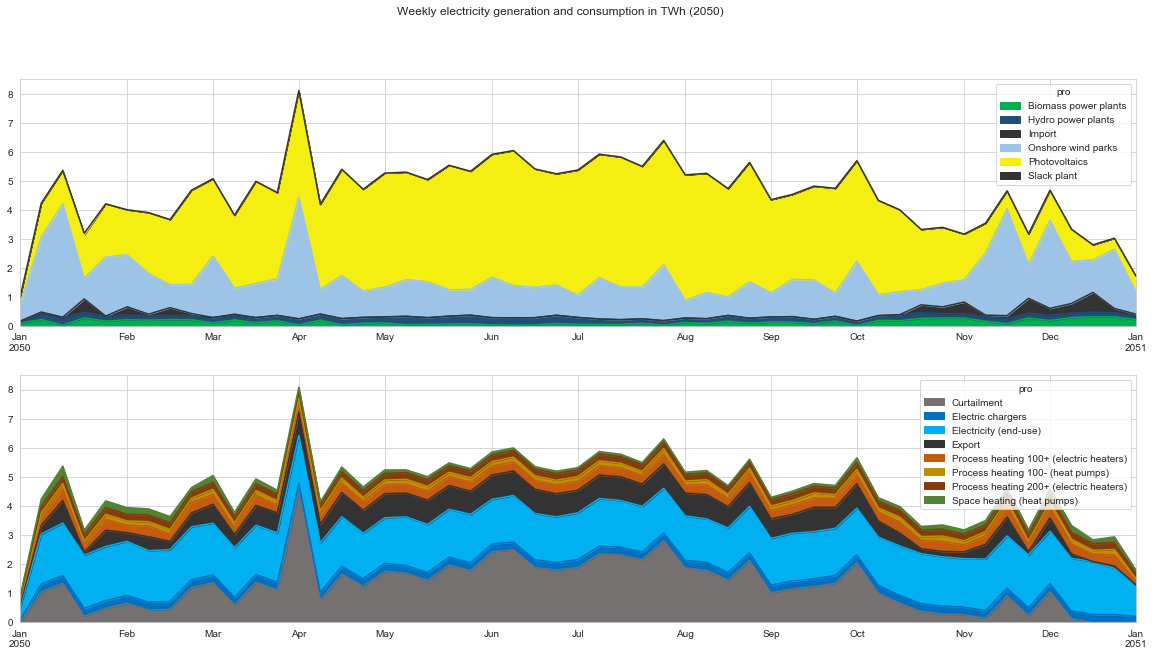

In [38]:
# Creating resampled plots
fig, axs = plt.subplots(2, 1, figsize = (20, 10))
(gen / 1e6).resample("W").sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in gen.columns], ax = axs[0])
(con / 1e6).resample('W').sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in con.columns], ax = axs[1])
fig.suptitle(f"Weekly electricity generation and consumption in TWh ({year})")

Text(0.5, 0.98, 'Daily electricity generation and consumption in TWh (2050)')

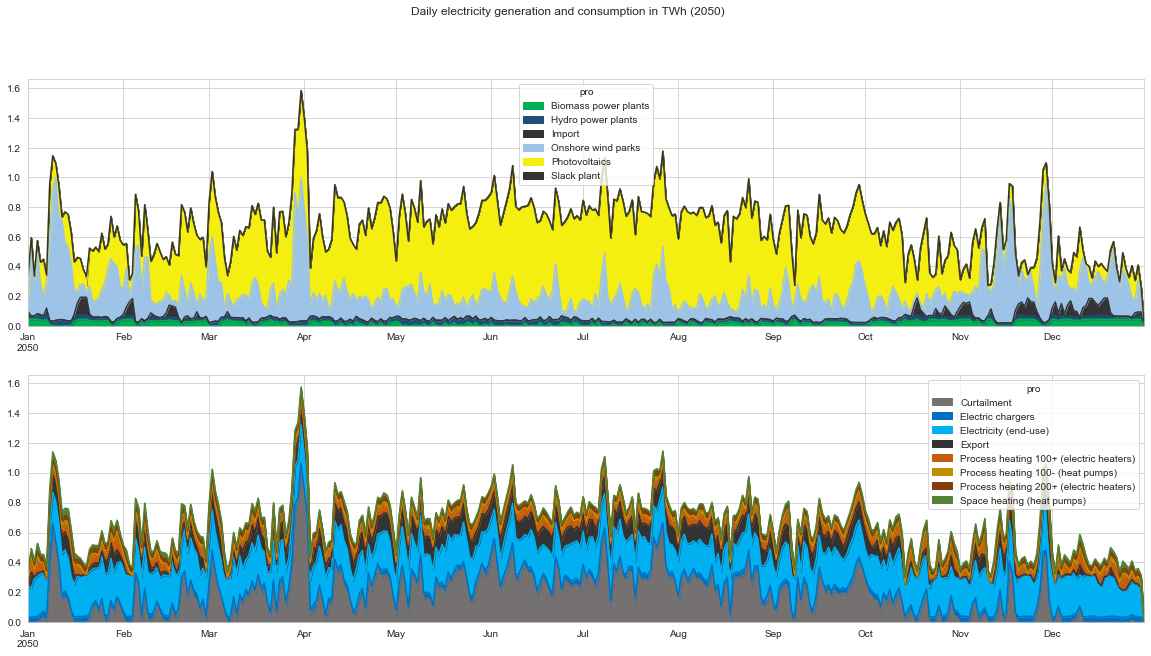

In [39]:
# Creating resampled plots
fig, axs = plt.subplots(2, 1, figsize = (20, 10))
(gen / 1e6).resample("D").sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in gen.columns], ax = axs[0])
(con / 1e6).resample('D').sum().plot(kind = "area", stacked = True, color = [color_dict.get(x, '#333333') for x in con.columns], ax = axs[1])
fig.suptitle(f"Daily electricity generation and consumption in TWh ({year})")

In [40]:
# Storage charging dataframe

dfs = []
for col in df[year]['e_sto_in'].unstack().columns:
    i = (df[year]['e_sto_in']
            .unstack()[col]
            .unstack()
            .dropna(axis = 1, how = 'all')
            .reset_index()
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .drop(['t', 'stf', 'sit'], axis = 1)
            )
    dfs.append(i)

e_sto_in = pd.concat(dfs, axis = 1)

In [41]:
# Storage discharging dataframe

dfs = []
for col in df[year]['e_sto_out'].unstack().columns:
    i = (df[year]['e_sto_out']
            .unstack()[col]
            .unstack()
            .dropna(axis = 1, how = 'all')
            .reset_index()
            .set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
            .drop(['t', 'stf', 'sit'], axis = 1)
            )
    dfs.append(i)

e_sto_out = pd.concat(dfs, axis = 1)

In [42]:
# Electricity prices

prices = {}

for year in years:
    prices[year] = (df[year]["res_vertex"]
                    .unstack()["Demand"]
                    .unstack()
                    .replace(0, np.nan).dropna(axis = 1, how = "all")
                    .replace(np.nan, 0)["Space heating"]
                    .reset_index()
                    #.set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                    .drop(['t', 'stf', 'sit'], axis = 1)
                    .rename(columns = {'Elec': f'Space heating price ({year})'})
                    )
    
sh_price = pd.concat(prices, axis = 1)

Text(0.5, 0.98, 'Duration curves of space heating prices in €/MWh')

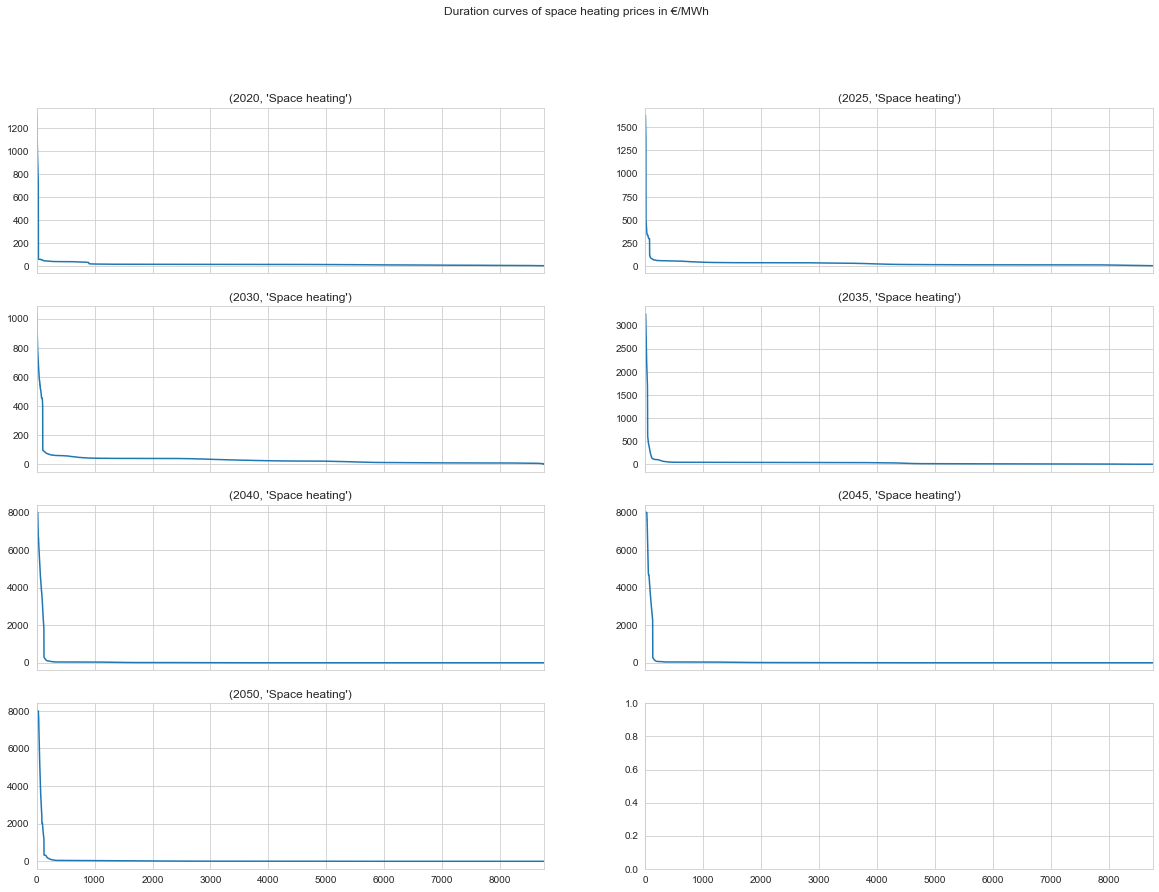

In [43]:
fig, axs = plt.subplots(len(sh_price.columns)//2 + len(sh_price.columns)%2, 2, sharex=True, figsize = (20, len(sh_price.columns)*2))

for idx, col in enumerate(sh_price.columns):
    sh_price[col].sort_values(ascending = False).plot(use_index = False, 
                                                               ax = axs[idx//2, idx%2]
                                                               )
    axs[idx//2, idx%2].set_title(f"{col}")
    
fig.suptitle(f'Duration curves of space heating prices in €/MWh')

In [44]:
# Electricity prices

prices = {}

for year in years:
    prices[year] = (df[year]["res_vertex"]
                    .unstack()["Stock"]
                    .unstack()
                    .replace(0, np.nan).dropna(axis = 1, how = "all")
                    .replace(np.nan, 0)["Elec"]
                    .reset_index()
                    #.set_index(pd.date_range(start = f"1/1/{year}", end = f"31/12/{year}", periods = 8760))
                    .drop(['t', 'stf', 'sit'], axis = 1)
                    .rename(columns = {'Elec': f'Electricity price ({year})'})
                    )
    
electricity_price = pd.concat(prices, axis = 1)

In [45]:
electricity_price.to_excel('price.xlsx')

In [46]:
electricity_price.describe().transpose()

,,count,mean,std,min,25%,50%,75%,max
2020,Electricity price (2020),8760.0,43.040367,23.469116,11.378788,39.246465,40.292857,40.292857,150.178306
2025,Electricity price (2025),8760.0,97.832509,425.740569,15.191489,41.010714,87.585807,100.000000,18264.795534
2030,Electricity price (2030),8760.0,93.694281,328.269064,0.000000,54.385725,58.103475,100.000000,8797.999516
2035,Electricity price (2035),8760.0,107.336969,404.654836,0.000000,21.357349,100.000000,100.000000,8139.578849
2040,Electricity price (2040),8760.0,244.730050,1839.898419,0.000000,0.000000,0.181943,21.648738,19998.000000
2045,Electricity price (2045),8760.0,220.035181,1709.843482,0.000000,0.000000,0.182053,22.085297,19998.000000
2050,Electricity price (2050),8760.0,205.495892,1624.505952,0.000000,0.000000,0.606276,22.528880,19998.000000


Text(0.5, 0.98, 'Duration curves of electricity prices in €/MWh')

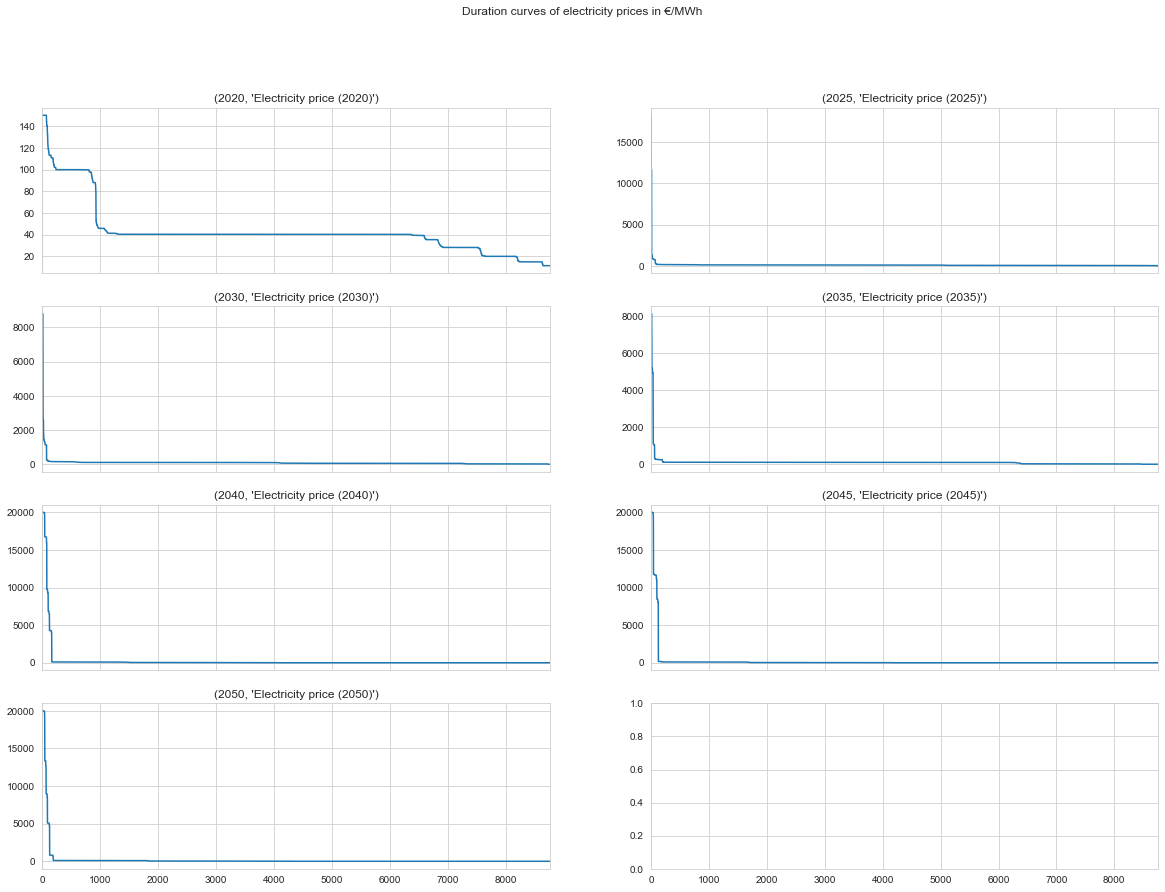

In [47]:
fig, axs = plt.subplots(len(electricity_price.columns)//2 + len(electricity_price.columns)%2, 2, sharex=True, figsize = (20, len(electricity_price.columns)*2))

for idx, col in enumerate(electricity_price.columns):
    electricity_price[col].sort_values(ascending = False).plot(use_index = False, 
                                                               ax = axs[idx//2, idx%2]
                                                               )
    axs[idx//2, idx%2].set_title(f"{col}")
    
fig.suptitle(f'Duration curves of electricity prices in €/MWh')

Text(0.5, 0.98, 'Load duration curves of energy storages 2050')

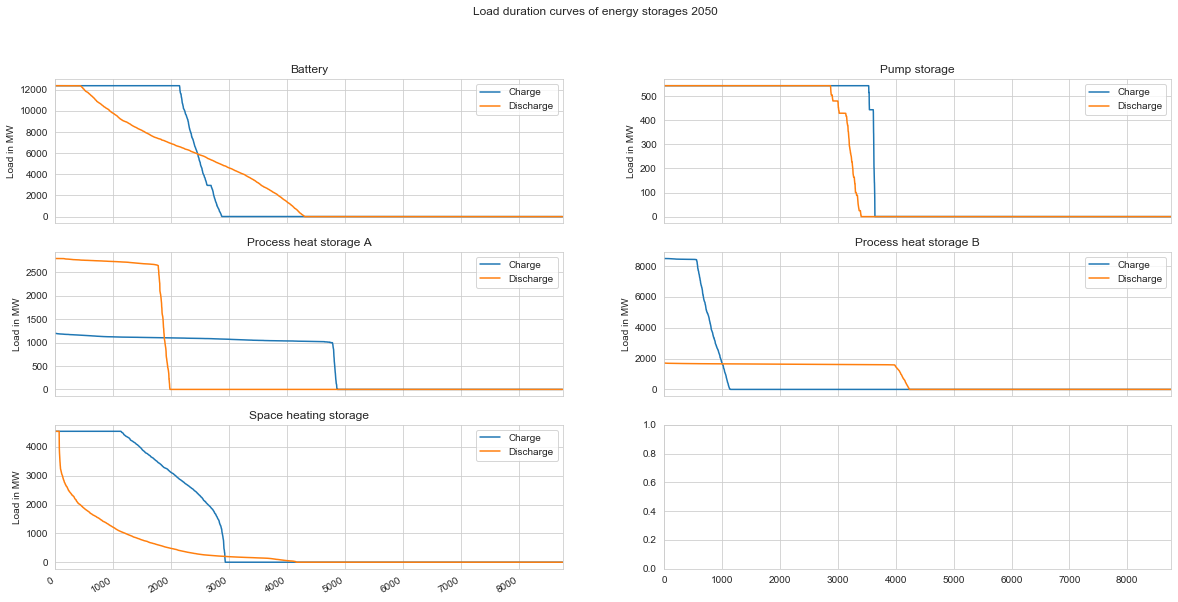

In [48]:
# Plotting load duration curves for energy storages

fig, axs = plt.subplots(len(e_sto_in.columns)//2 + len(e_sto_in.columns)%2, 2, figsize = (20, len(e_sto_in.columns)*2), sharex = True)

for idx, tech in enumerate(e_sto_in.columns):

    e_sto_in[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx//2, idx%2])
    e_sto_out[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx//2, idx%2])
    axs[idx//2, idx%2].set_title(tech)
    axs[idx//2, idx%2].set_ylabel('Load in MW')
    axs[idx//2, idx%2].legend(['Charge', 'Discharge'])

fig.suptitle(f'Load duration curves of energy storages {year}')

Text(0.5, 0.98, 'Load duration curves of consumption 2050')

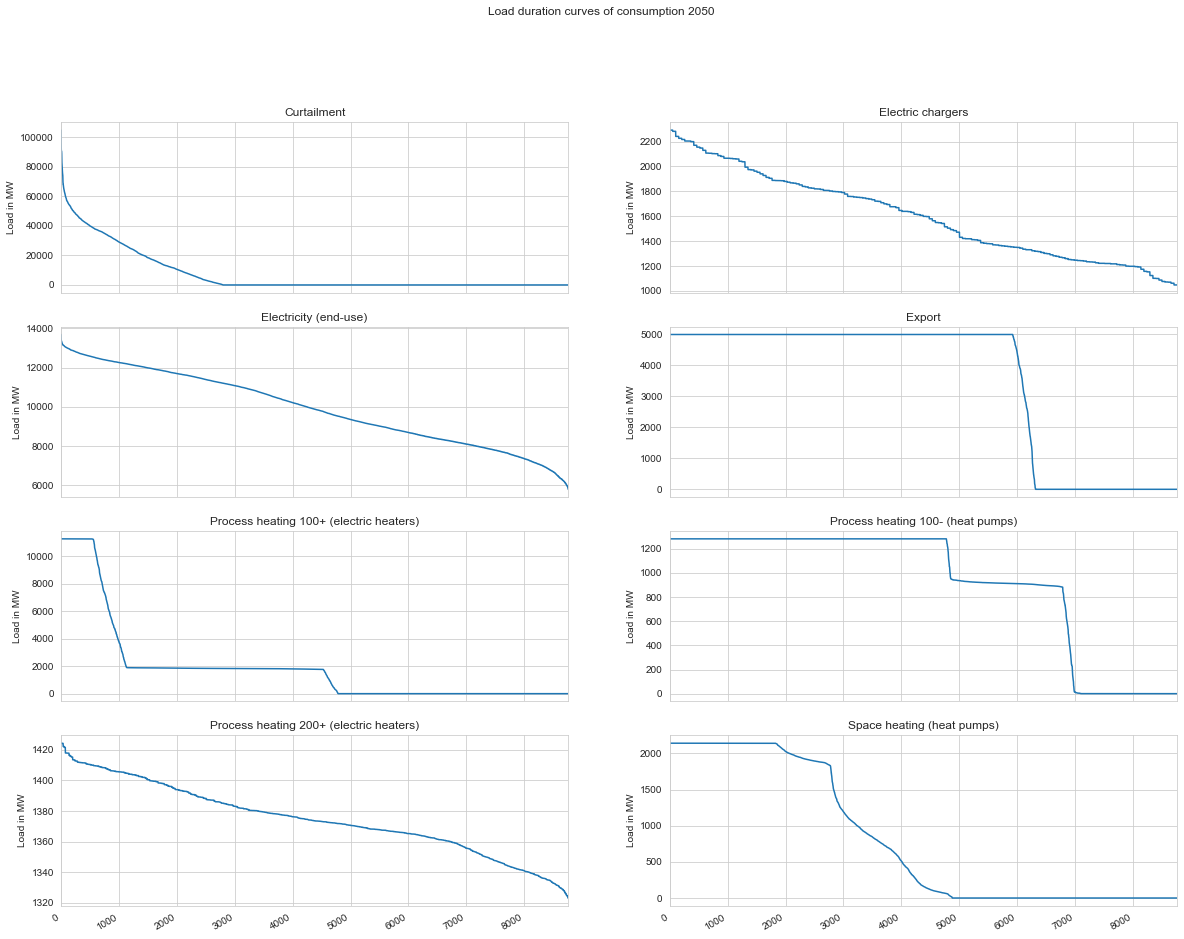

In [49]:
# Plotting load duration curves for energy consumption technologies

fig, axs = plt.subplots(len(con.columns)//2 + len(con.columns)%2, 2, figsize = (20, len(con.columns)*2), sharex = True)

for idx, tech in enumerate(con.columns):

    con[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx//2, idx%2])
    axs[idx//2, idx%2].set_title(tech)
    axs[idx//2, idx%2].set_ylabel('Load in MW')

fig.suptitle(f'Load duration curves of consumption {year}')

Text(0.5, 0.98, 'Load duration curves of generation 2050')

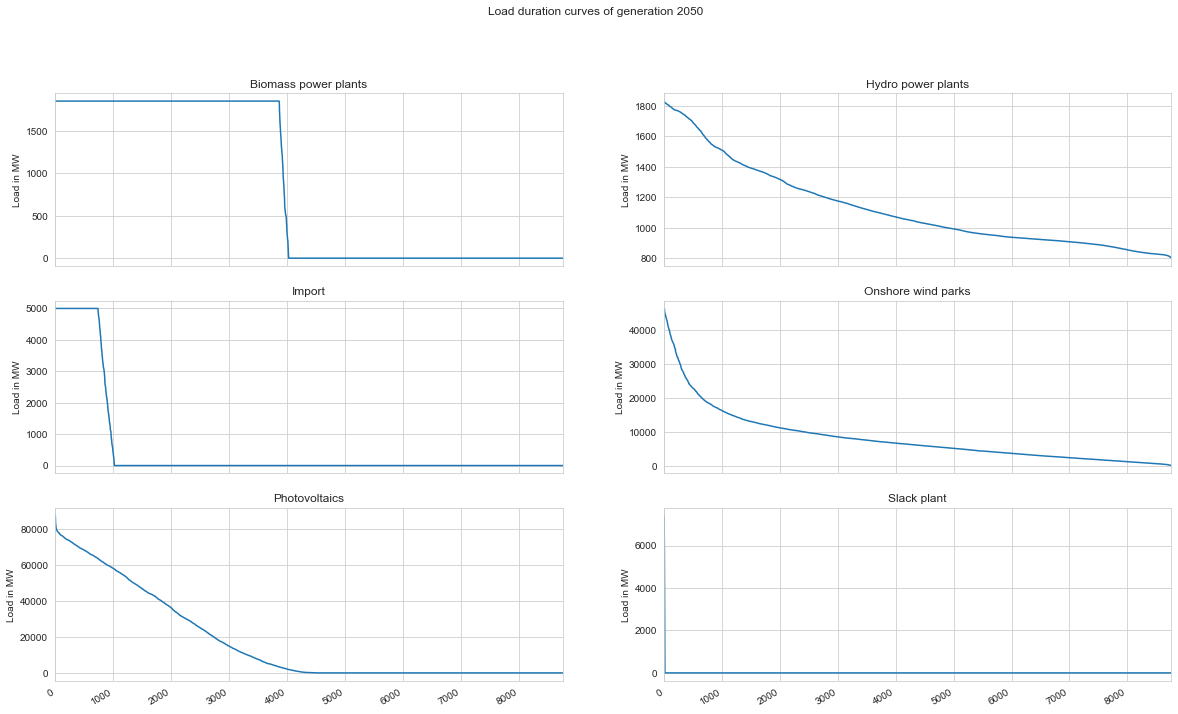

In [50]:
# Plotting load duration curves for energy generation technologies

fig, axs = plt.subplots(len(gen.columns)//2 + len(gen.columns)%2, 2, figsize = (20, len(gen.columns)*2), sharex = True)

for idx, tech in enumerate(gen.columns):

    gen[tech].sort_values(ascending = False).plot(use_index = False, ax = axs[idx//2, idx%2])
    axs[idx//2, idx%2].set_title(tech)
    axs[idx//2, idx%2].set_ylabel('Load in MW')

fig.suptitle(f'Load duration curves of generation {year}')